# Classification of Hazardous/Nonhazardous Nearest Earth Objects (NEOs)

<p>Section: 008<br>
Group: 34<br>
Authors: Philip Chen, Liam Guetg, Vanesse Li, Ada Jiang</p>

### Introduction:
A near-earth object (NEO) is an asteroid or comet with an orbit that approaches a point within 1.3 astronomical units of the sun.<sup>[1](#1)</sup> The JPL Center for NEO Studies conducts research on these objects by computing orbits and assessing the impact risk (of collision) of individual NEOs over time.<sup>[3](#1)</sup>

In this project, we want to expand the JPL's research. To determine the impact risk of a NEO, we must predict its trajectory by studying observable attributes.<sup>[2](#1)</sup> However, NEOs are irregularly shaped and are constantly moving, so measurements are estimates are taken at various times, distances and phase angles.<sup>[3](#1)</sup> Considering this imperfect data, we want to create an effective binary classifier that uses the K-nearest neighbours algorithm to predict whether a given NEO is harmful or not based on various quantitative measurements. A NEO's hazardous designation changes based on updated trajectory predictions, so it is more important that our classifier correctly identify a hazardous NEO as hazardous (i.e., have high recall) than prevent false positives.<sup>[3](#1)</sup>. Our question is, which predictors and what K value will produce a classifier that predicts a NEO's hazardous designation with the highest accuracy and recall?

#### NEO Dataset
This dataset compiles the list of NASA certified asteroids that are classified as NEOs.<sup>[4](#1)</sup>

1. **id** (unique identifier for each asteroid)
2. **name** (name of asteroid given by NASA)
3. **est_diameter_min** (minimum estimated diameter in kilometres)
4. **est_diameter_max** (maximum estimated diameter in kilometres)
5. **relative_velocity** (velocity relative to earth)
6. **miss_distance** (distance in kilometres missed)
7. **orbiting_body** (planet that the asteroid orbits)
8. **sentry_object** (included in JPL Sentry System?)
9. **absolute_magnitude** (intrinsic mean brightness)<sup>[5](#1)</sup>
10. **hazardous** (boolean factor that indicates whether asteroid is harmful or not)

### Preliminary exploratory data analysis:

In [1]:
# Run this cell before continuing
install.packages("cowplot")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
# Run this cell before continuing
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

Rows: 90836 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): name, orbiting_body
dbl (6): id, est_diameter_min, est_diameter_max, relative_velocity, miss_dis...
lgl (2): sentry_object, hazardous

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<fct>
2162635,162635 (2000 SS164),1.19827080,2.67941497,13569.25,54839744,Earth,FALSE,16.73,FALSE
2277475,277475 (2005 WK4),0.26580000,0.59434687,73588.73,61438127,Earth,FALSE,20.00,TRUE
2512244,512244 (2015 YE18),0.72202956,1.61450717,114258.69,49798725,Earth,FALSE,17.83,FALSE
3596030,(2012 BV13),0.09650615,0.21579430,24764.30,25434973,Earth,FALSE,22.20,FALSE
3667127,(2014 GE35),0.25500869,0.57021676,42737.73,46275567,Earth,FALSE,20.09,TRUE
54138696,(2021 GY23),0.03635423,0.08129053,34297.59,40585691,Earth,FALSE,24.32,FALSE


hazardous,count
<fct>,<int>
FALSE,300
TRUE,300


orbiting_body,count
<chr>,<int>
Earth,600


est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.2103551,0.4703682,54135.45,37723197,22.0013


[1] 0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


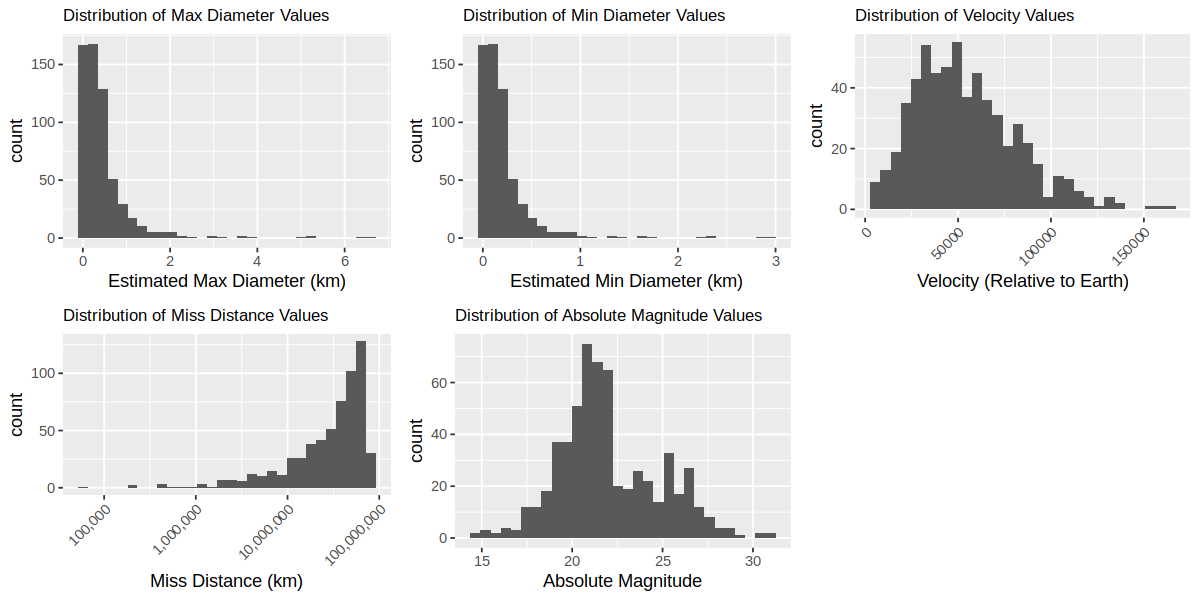

In [3]:
options(repr.plot.width = 10, repr.plot.height = 5)
url <- "https://raw.githubusercontent.com/LongTortue/DSCI100-Group-Project/main/neo.csv"
neo_data <- read_csv(url)

neo_data <- neo_data |>
mutate(sentry_object = as_factor(sentry_object), hazardous = as_factor(hazardous))
head(neo_data) # transforming the categorical variables into factors

# as the data is unbalanced (81000 false to 9000 true), we will create a new dataset that is balanced

neo_data_false <- neo_data |>
filter(hazardous == "FALSE") |>
sample_n(400)
neo_data_true <- neo_data |>
filter(hazardous == "TRUE") |>
sample_n(400)
neo_data_balanced <- rbind(neo_data_false, neo_data_true) # balanced dataset

neo_data_split <- initial_split(neo_data_balanced, prop = 0.75, strata = hazardous)
neo_data_train <- training(neo_data_split)
neo_data_test <- testing(neo_data_split)

neo_count <- neo_data_train |>
group_by(hazardous) |>
summarize(count = n())
neo_count # number of observations in each class

neo_count_orbiting <- neo_data_train |>
group_by(orbiting_body) |>
summarize(count = n())
neo_count_orbiting # all observations have orbiting bodies of Earth

neo_mean <- neo_data_train |>
select(-id, -name, -orbiting_body, -sentry_object, -hazardous) |>
map_df(mean)
neo_mean # mean of predictors

neo_na_count <- sum(is.na(neo_data_train))
neo_na_count # no missing values in our dataset

# plots visualizing distribution of data, and shown next to each other
neo_plot_max_diameter <- neo_data_train |>
ggplot(aes(x = est_diameter_max)) +
geom_histogram() +
xlab("Estimated Max Diameter (km)") +
ggtitle("Distribution of Max Diameter Values") +
theme(plot.title = element_text(size = 10))

neo_plot_min_diameter <- neo_data_train |>
ggplot(aes(x = est_diameter_min)) +
geom_histogram() +
xlab("Estimated Min Diameter (km)") +
ggtitle("Distribution of Min Diameter Values") +
theme(plot.title = element_text(size = 10))

neo_plot_velocity <- neo_data_train |>
ggplot(aes(x = relative_velocity)) +
geom_histogram() +
theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
xlab("Velocity (Relative to Earth)") +
ggtitle("Distribution of Velocity Values") +
theme(plot.title = element_text(size = 10))

neo_plot_miss_distance <- neo_data_train |>
ggplot(aes(x = miss_distance)) +
geom_histogram() +
scale_x_log10(labels = label_comma()) +
theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
xlab("Miss Distance (km)") +
ggtitle("Distribution of Miss Distance Values") +
theme(plot.title = element_text(size = 10))

neo_plot_absolute_magnitude <- neo_data_train |>
ggplot(aes(x = absolute_magnitude)) +
geom_histogram() +
xlab("Absolute Magnitude") +
ggtitle("Distribution of Absolute Magnitude Values") +
theme(plot.title = element_text(size = 10))

plot_grid(neo_plot_max_diameter, neo_plot_min_diameter, neo_plot_velocity, 
          neo_plot_miss_distance, neo_plot_absolute_magnitude)

### Methods:
The NEO dataset is large and may slow down the server, so we propose using a random subset of the data for this project.

To perform a K-nearest neighbours classification, we will: 

1. Split the data into a training and test set based on the `hazardous` variable.
2. Further split up the training dataset for cross-validation (5 folds, training and validation sets).
3. Create a standardization recipe that applies preprocessing steps on all selected predictor variables and specifies `hazardous` variable as the response.
4. Create a `nearest_neighbors` model specification that will tune the K parameter (number of neighbours).
5. Combine the recipe and model in a `workflow()`. Train and tune the classifier on the training and validation sets to produce performance statistics (e.g., accuracy and recall values) for a range of K values.
6. Make a new model specification using the K value that yields both high accuracy and high recall values and retrain the classifier on the unsplit training set.
7. Evaluate the performance of the classifier using the test set.  

We will use the `est_diameter_min`, `est_diameter_max`, `relative_velocity`, `miss_distance`, and `absolute_magnitude` columns for classification. We selected these variables because the JPL Sentry System (an automated collision monitory system) uses these types of variables to calculate impact risk and consequently label the hazardous designation of each asteroid.<sup>[6](#1)</sup>

Some ways we will visualize our results:
1. Create scatterplots of predictor variables against other predictor variables (e.g., est_diameter_min versus relative_velocity) and colouring the points to represent their hazardous label.
2. Create lineplots of accuracy/recall versus number of neighbours (K) to determine the "best" value of K.

### Expected outcomes and significance:
Through this data analysis, we will identify the variables and the value of K that helps us efficiently classify the potential risk of a NEO. We will use different indicators such as distance, size, and speed to evaluate if a NEO is hazardous (causing significant geological damage) or not.<sup>[7](#1)</sup>

These findings will have an impact on everyone's safety on Earth. With a reliable classification model, we can to determine whether a NEO poses a significant risk to the planet before any collision occurs. Being able to classify an object's hazardousness through observable attributes allows us to be ready ahead of time and minimize potential damage. 

Researchers can conduct further research on the types of damage NEOs can cause and their impacts. They can explore how to redirect the trajectory of an Earth-bound object and analyze alternative protective measures to minimize potential harm.<sup>[7](#1)</sup> Additionally, researchers may identify more predictive factors of a hazardous NEO, and develop even better classifiers.

<a id="1"></a> 
### References
1. *Keeping an eye on Space Rocks.* (n.d.) NASA/JPL Caltech. https://www.jpl.nasa.gov/keeping-an-eye-on-space-rocks
2. *NEO Basics.* (n.d.) NASA/JPL CNEOS. https://cneos.jpl.nasa.gov/about/target_earth.html
3. *Impact Risk.* (n.d.) NASA/JPL CNEOS. https://cneos.jpl.nasa.gov/risk/intro.html
4. Vani, Sameep. *NASA - Nearest Earth Objects.* (n.d.) Kaggle. Retrieved October 26, 2023, from https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects
5. *Discovery Statistics.* (n.d.) NASA/JPL CNEOS. https://cneos.jpl.nasa.gov/stats/
6. *Sentry: Earth Impact Monitoring.* (n.d.) NASA/JPL CNEOS. https://cneos.jpl.nasa.gov/sentry/
7. Tedesco, Edward. *Earth impact hazard.* (n.d.) Britannica. https://www.britannica.com/science/Earth-impact-hazard/Determining-the-hazard-potential-of-an-NEO